<a href="https://colab.research.google.com/github/mostafadentist/python-ipynb/blob/main/Project_Scheduling_(PERT_%26_CPM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.9 MB/s eta 0:00:00


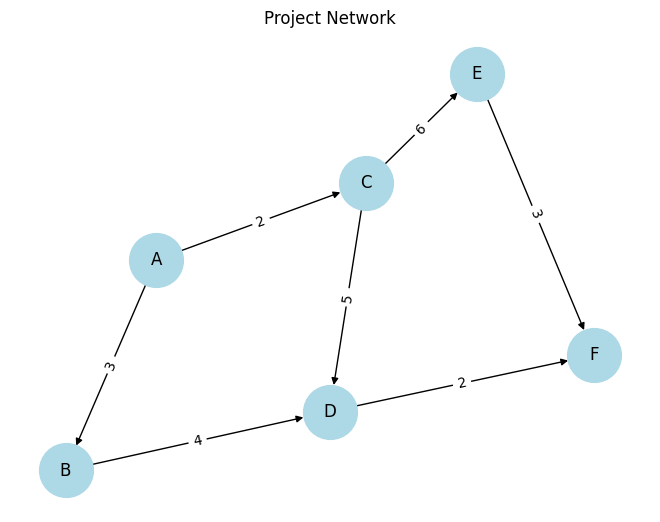

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Define activities: (start, end, duration)
activities = [
    ("A", "B", 3),
    ("A", "C", 2),
    ("B", "D", 4),
    ("C", "D", 5),
    ("C", "E", 6),
    ("D", "F", 2),
    ("E", "F", 3)
]

G = nx.DiGraph()
for u,v,d in activities:
    G.add_edge(u,v, duration=d)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue")
labels = nx.get_edge_attributes(G,'duration')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Project Network")
plt.show()

In [38]:
def cpm(G):
    # Forward pass
    earliest = {node: 0 for node in G.nodes()}
    for u in nx.topological_sort(G):   # iterate over nodes
        for _, succ, data in G.out_edges(u, data=True):
            earliest[succ] = max(earliest[succ], earliest[u] + data['duration'])

    project_duration = max(earliest.values())

    # Backward pass
    latest = {node: project_duration for node in G.nodes()}
    for u in reversed(list(nx.topological_sort(G))):  # reverse order
        for pred, _, data in G.in_edges(u, data=True):
            latest[pred] = min(latest[pred], latest[u] - data['duration'])

    # Slack = Latest - Earliest
    slack = {node: latest[node] - earliest[node] for node in G.nodes()}

    return project_duration, earliest, latest, slack

In [39]:
duration, earliest, latest, slack = cpm(G)
print("Project Duration =", duration)
print("Earliest Times:", earliest)
print("Latest Times:", latest)
print("Slack:", slack)

Project Duration = 11
Earliest Times: {'A': 0, 'B': 3, 'C': 2, 'D': 7, 'E': 8, 'F': 11}
Latest Times: {'A': 0, 'B': 5, 'C': 2, 'D': 9, 'E': 8, 'F': 11}
Slack: {'A': 0, 'B': 2, 'C': 0, 'D': 2, 'E': 0, 'F': 0}


In [40]:
# Example PERT activity times
activities_pert = {
    "A": (2,3,4),   # (a,m,b)
    "B": (1,4,7),
    "C": (2,2,8)
}

expected = {act: (a+4*m+b)/6 for act,(a,m,b) in activities_pert.items()}
variance = {act: ((b-a)/6)**2 for act,(a,m,b) in activities_pert.items()}

print("Expected Times:", expected)
print("Variance:", variance)

Expected Times: {'A': 3.0, 'B': 4.0, 'C': 3.0}
Variance: {'A': 0.1111111111111111, 'B': 1.0, 'C': 1.0}


In [41]:
from scipy.stats import norm

# Suppose project mean duration = 22, variance = 9
mu = 22
sigma = 3  # sqrt(variance)
deadline = 25

z = (deadline - mu)/sigma
prob = norm.cdf(z)

print(f"Probability of completing by {deadline} =", round(prob,3))

Probability of completing by 25 = 0.841


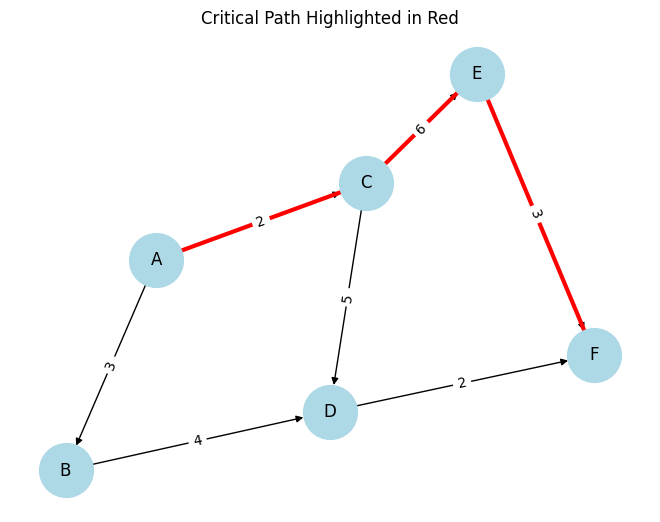

In [42]:
critical_edges = [(u,v) for u,v,d in activities if slack[u]==0 and slack[v]==0]

nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, edgelist=critical_edges, edge_color="r", width=3)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Critical Path Highlighted in Red")
plt.show()